## Вариант 2

**Цель:** Контроль пространственных размерностей через свертки и пулинг.

- Спроектируйте сеть для выхода `(64, 16, 16)` за **не более 3 слоев свертки**.
- **Условие:** Используйте как минимум один слой с `padding=0`, чтобы часть пространственной информации была потеряна. Можно менять в таких условиях kernel_size и stride.
- **Эксперимент:** Сравните выход с использованием `padding=0` и `padding=1`, оцените разницу в размерности и среднее значение активаций.

In [17]:
import torch
import torch.nn as nn


input_tensor = torch.randn(1, 3, 64, 64)

class ModelWithPadding0(nn.Module):
    def __init__(self):
        super(ModelWithPadding0, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=2, padding=0)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1)
        self.relu3 = nn.ReLU()

    def forward(self, x):
        print("padding 0")
        x = self.relu1(self.conv1(x))
        print(f"После 1 слоя: Размер = {x.shape}")
        x = self.relu2(self.conv2(x))
        print(f"После 2 слоя: Размер = {x.shape}")
        x = self.relu3(self.conv3(x))
        print(f"После 3 слоя: Размер = {x.shape}, Средняя активация = {x.mean().item()}")
        return x

class ModelWithPadding1(nn.Module):
    def __init__(self):
        super(ModelWithPadding1, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=2, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1)
        self.relu3 = nn.ReLU()

    def forward(self, x):
        print("\npadding 1")
        x = self.relu1(self.conv1(x))
        print(f"После 1 слоя: Размер = {x.shape}")
        x = self.relu2(self.conv2(x))
        print(f"После 2 слоя: Размер = {x.shape}")
        x = self.relu3(self.conv3(x))
        print(f"После 3 слоя: Размер = {x.shape}, Средняя активация = {x.mean().item()}")
        return x
    


model0 = ModelWithPadding0()
final_output_0 = model0(input_tensor)

model1 = ModelWithPadding1()
final_output_1 = model1(input_tensor)



padding 0
После 1 слоя: Размер = torch.Size([1, 16, 31, 31])
После 2 слоя: Размер = torch.Size([1, 32, 31, 31])
После 3 слоя: Размер = torch.Size([1, 64, 16, 16]), Средняя активация = 0.042105432599782944

padding 1
После 1 слоя: Размер = torch.Size([1, 16, 32, 32])
После 2 слоя: Размер = torch.Size([1, 32, 32, 32])
После 3 слоя: Размер = torch.Size([1, 64, 16, 16]), Средняя активация = 0.04614740237593651


При padding=0 происходит  потеря информации по краям изображения. Размер карты признаков сразу уменьшается до 31 на 31. С padding=1 добавление отступов позволяет при свертке учитывать крайние пиксели изображения, сохраняя больше информации. 
Небольшая разница в среднем значении активаций возникает из-за потери краевой информации.

## Вариант 5. Контроль градиентов через глубину

**Цель:** Изучение поведения градиентов в глубокой сети.

- Разработайте сеть с **не менее 6 слоев**, которая выводит тензор `(batch, 64, 8, 8)`.
- **Условие:** Слои должны чередоваться между `Conv2d` и `ReLU`, при этом **градиенты первого слоя должны быть меньше градиентов последнего** после одной итерации `backward()` на случайных данных.
- **Эксперимент:** Визуализируйте градиенты по слоям и объясните, почему градиенты убывают или растут.

Градиент первого слоя(conv1): 0.0008434432675130665
Градиент последнего слоя (conv6): 0.01220051571726799


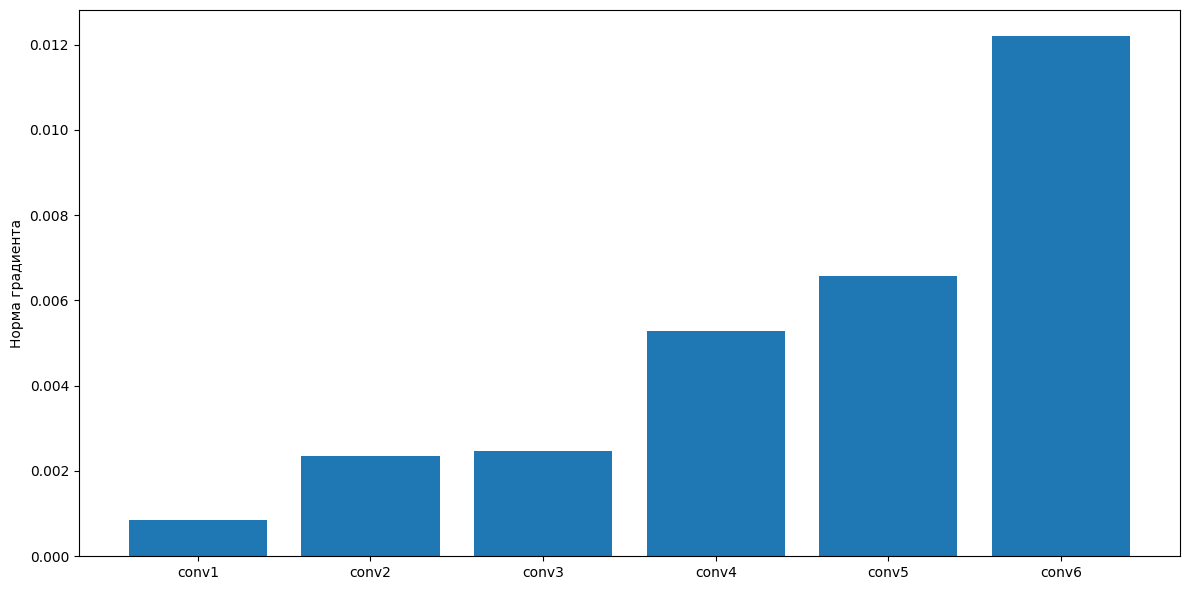

In [18]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np


class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
    
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()

        self.conv2 = nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1)
        self.relu2 = nn.ReLU()
        
        self.conv3 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.relu3 = nn.ReLU()
        
        self.conv4 = nn.Conv2d(32, 32, kernel_size=3, stride=2, padding=1)
        self.relu4 = nn.ReLU()

        self.conv5 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.relu5 = nn.ReLU()
        
        self.conv6 = nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1)
        

        self.layers = nn.ModuleList([
            self.conv1, self.relu1,
            self.conv2, self.relu2,
            self.conv3, self.relu3,
            self.conv4, self.relu4,
            self.conv5, self.relu5,
            self.conv6
        ])

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x


def get_conv_layers(model):

    conv_layers = []
    for name, module in model.named_modules():
        if isinstance(module, nn.Conv2d):
            conv_layers.append((name, module))
    return conv_layers

def run_experiment():

    model = CNN()
    

    input_tensor = torch.randn(4, 3, 64, 64)
    
    target_tensor = torch.randn(4, 64, 8, 8)
    
    output = model(input_tensor)
    
    loss_fn = nn.MSELoss()
    loss = loss_fn(output, target_tensor)
    model.zero_grad()
    loss.backward()
    
    conv_layers = get_conv_layers(model)
    gradient_magnitudes = []
    layer_names = []
    
    for name, layer in conv_layers:
        if layer.weight.grad is not None:
            grad_norm = layer.weight.grad.norm().item()
            gradient_magnitudes.append(grad_norm)
            layer_names.append(name)


    grad_first = gradient_magnitudes[0]
    grad_last = gradient_magnitudes[-1]
    
    condition_met = grad_first < grad_last
    plot_filename = None 

    print(f"Градиент первого слоя({layer_names[0]}): {grad_first}")
    print(f"Градиент последнего слоя ({layer_names[-1]}): {grad_last}")



    plt.figure(figsize=(12, 6))
    plt.bar(layer_names, gradient_magnitudes)
    plt.ylabel('Норма градиента')
    plt.tight_layout()
    plt.show()


    
    return gradient_magnitudes, layer_names, condition_met, plot_filename

if __name__ == '__main__':
    gradient_magnitudes, layer_names, condition_met, plot_filename = run_experiment()
    analysis = {
        "gradient_magnitudes": gradient_magnitudes,
        "layer_names": layer_names,
        "condition_met": condition_met
    }



В данной архитектуре градиент растет от первого слоя к последнему, достигая максимума на последнем слое. Это происходит потому, что  градиент на каждом шаге умножается на веса и производную функции активации. Поскольку используется функция ReLU, которая не ослабляет градиент, и не используем нормализацию, это умножение приводит к тому, что градиент ошибки увеличивается к выходному слою. 